# BITCOIN

In [3]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

# Machine Learning Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

# Metrics and Evaluation
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, explained_variance_score, r2_score,
    mean_poisson_deviance, mean_gamma_deviance, accuracy_score
)

# Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


# File Handling
import os

# Math
import math

# Time series models
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Statistics
from scipy.stats import f_oneway

# CLASS DEFINITION

In [2]:
class BTC(object):
    def __init__(self, dataset, granularity):
        if not isinstance(dataset, pd.DataFrame):
            raise ValueError("Input 'dataset' must be a pandas DataFrame.")
        
        self.dataset = dataset.copy()
        self.granularity = granularity
        
        self.dataset['time'] = pd.to_datetime(self.dataset['time'])
        self.dataset.set_index('time', inplace=True)
        
        training_size = int(len(self.dataset) * 0.7)
        self.train = self.dataset.iloc[:training_size]
        self.test = self.dataset.iloc[training_size:]
        
        
    def __str__(self):
        return 'BTC-' + str(self.granularity)
    
    def show_dataset(self, head=False, tail=False):       
        if head:
            return self.dataset.head(head)
        
        elif tail:
            return self.dataset.tail(tail)
        
        else:
            return self.dataset
    
    def reset_train_test(self, train_ratio=0.7):
        if 0 < train_ratio < 1:
            training_size = int(len(self.dataset) * train_ratio)

            self.train = self.dataset.iloc[:training_size]
            self.test = self.dataset.iloc[training_size:]

            print("Train ratio: {}".format(train_ratio))
            print("Test ratio: {}".format(1-train_ratio))
        
        else:
            print("Please, train ratio between 0 and 1")
            
    def split_data(self, feature_columns, target_column):
        X_train = self.train[feature_columns]
        Y_train = self.train[target_column]

        X_test = self.test[feature_columns]
        Y_test = self.test[target_column]

        return X_train, Y_train, X_test, Y_test
    
    def plot_candle(self):
        mpf.plot(self.dataset, type='candle', volume=True, style='yahoo', figsize=(20,10))
    
    def plot_heatmap(self):    
        plt.figure(figsize=(10,5))

        correlation = self.dataset.corr()
        sns.heatmap(correlation, annot=True)

        plt.show()
        
    def show_nulls(self):
        return self.dataset.isna().sum()
    
    def check_time_gaps(self):
        return (self.dataset.index[1:]-self.dataset.index[:-1]).value_counts().head()

    def dicker_fuller(self, column):
        print ('Dickey-Fuller Test indicates:')
        df_test = adfuller(self.dataset[column], regression='ct', autolag='AIC')
        output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        print(output)

    def print_granularity(self, unit='seconds'):
        units = {'seconds': 1, 'minutes': 1/60, 'hours': 1/3600}
        
        interval = self.granularity * units[unit]
        
        print('Intervals of {} {}'.format(interval, unit))

# CLASS DEFINITION (MODELS)

In [3]:
class Model(object):
    def __init__(self, model):
        self.model = model  
        
    def fit(self):
        return self.model.fit()
    
    def predict(self, BTC):
        feature_columns = ['open']
        target_column = ['close']

        X_train, y_train, X_test, y_test = BTC.split_data(feature_columns, target_column)

        # Initialize the Random Forest Regressor model
        my_model = self.model
        my_model.fit(X_train, y_train)

        test_predict = my_model.predict(X_test)
        
        mae = mean_absolute_error(y_test, test_predict)
        rmse = math.sqrt(mean_squared_error(y_test, test_predict))

        print("-"*100)
        print("Mean Absolute Error - MAE : " + str(mae))
        print("Root Mean squared Error - RMSE : " + str(rmse))
        print("-"*100)

        test_predict = test_predict.reshape(-1,1)

        return test_predict, mae, rmse
    
    def print_accuracy(self, BTC, predicted_values):
        mae = mean_absolute_error(BTC.test['close'].values, predicted_values)

        percentage_accuracy = 100 - (mae / BTC.test.values.mean()) * 100
        
        print("The accuracy of the model is {}%".format(percentage_accuracy))
    
    def plot_predictions(self, BTC, test_predict):
        test_predict = test_predict.reshape(-1,1)
        train_shape = BTC.train.shape[0]

        # Your original code for plotting the black and red lines
        fig, ax = plt.subplots(figsize=(15, 6))
        sns.lineplot(x=BTC.dataset.index[:train_shape], y=BTC.dataset['close'][:train_shape], color='black')
        sns.lineplot(x=BTC.dataset.index[train_shape:], y=BTC.dataset['close'][train_shape:], color='red')

        # Plot the test data on top of the red line
        sns.lineplot(x=BTC.dataset.index[train_shape:], y=test_predict[:, 0], color='blue')

        # Formatting
        ax.set_title('BitCoin Value Evolution', fontsize=20, loc='center', fontdict=dict(weight='bold'))
        ax.set_xlabel('Date', fontsize=16, fontdict=dict(weight='bold'))
        ax.set_ylabel('Daily Sales', fontsize=16, fontdict=dict(weight='bold'))
        plt.tick_params(axis='y', which='major', labelsize=16)
        plt.tick_params(axis='x', which='major', labelsize=16)

        # Customize legend labels and colors
        plt.legend(loc='upper right', labels=['train', 'test', 'predicted test'], 
                   handles=[plt.Line2D([0], [0], color='black', label='train'),
                            plt.Line2D([0], [0], color='red', label='test'),
                            plt.Line2D([0], [0], color='blue', label='predicted test')])

        plt.show()



# DATASETS

In [4]:
path = os.path.abspath('Datasets/BTC-EUR')

BTC_60 = BTC(pd.read_csv(os.path.join(path, 'BTC-EUR-60.csv')), 60)
BTC_300 = BTC(pd.read_csv(os.path.join(path, 'BTC-EUR-300.csv')), 300)
BTC_900 = BTC(pd.read_csv(os.path.join(path, 'BTC-EUR-900.csv')), 900)
BTC_3600 = BTC(pd.read_csv(os.path.join(path, 'BTC-EUR-3600.csv')), 3600)
BTC_21600 = BTC(pd.read_csv(os.path.join(path, 'BTC-EUR-21600.csv')), 21600)
BTC_86400 = BTC(pd.read_csv(os.path.join(path, 'BTC-EUR-86400.csv')), 86400)

<Axes: xlabel='open', ylabel='close'>

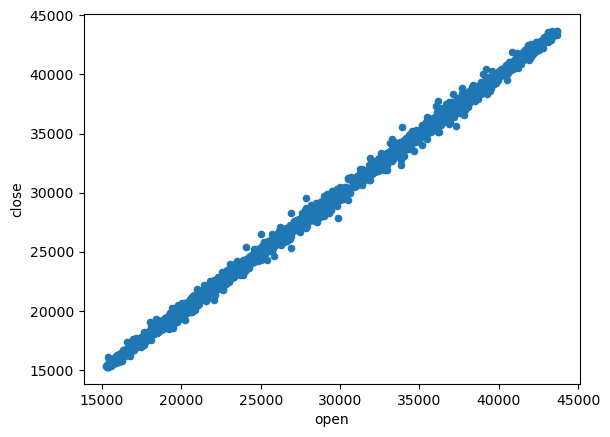

In [14]:
BTC_3600.show_dataset().plot.scatter(x="open", y="close")

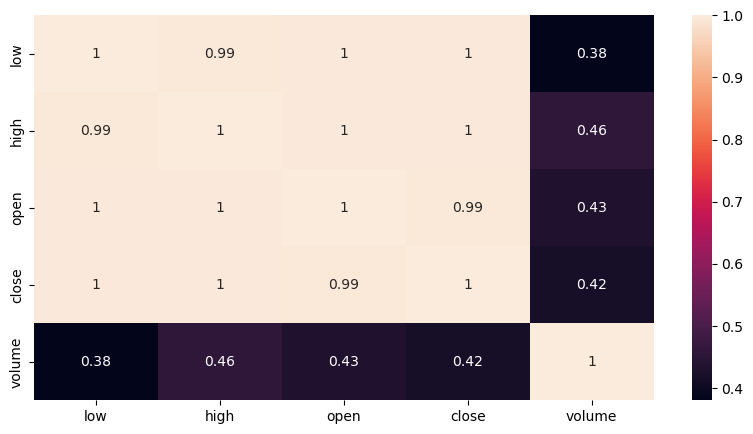

In [6]:
BTC_86400.plot_heatmap()

### Dealing with missing data

In [6]:
BTC_60.check_time_gaps()

0 days 00:01:00    702003
0 days 00:02:00     68069
0 days 00:03:00     13542
0 days 00:04:00      3740
0 days 00:05:00      1310
Name: time, dtype: int64

In [7]:
BTC_60.check_time_gaps()

0 days 00:01:00    702003
0 days 00:02:00     68069
0 days 00:03:00     13542
0 days 00:04:00      3740
0 days 00:05:00      1310
Name: time, dtype: int64

In [8]:
BTC_300.check_time_gaps()

0 days 00:05:00    180329
0 days 00:10:00       432
0 days 00:15:00        10
0 days 04:50:00         1
0 days 00:20:00         1
Name: time, dtype: int64

In [9]:
BTC_900.check_time_gaps()

0 days 00:15:00    60407
0 days 04:45:00        1
0 days 00:30:00        1
0 days 00:45:00        1
Name: time, dtype: int64

In [10]:
BTC_3600.check_time_gaps()

0 days 01:00:00    15102
0 days 05:00:00        1
Name: time, dtype: int64

In [11]:
BTC_21600.check_time_gaps()

0 days 06:00:00    2517
Name: time, dtype: int64

In [12]:
BTC_86400.check_time_gaps()

1 days    628
Name: time, dtype: int64

# REGRESSION MODELS

In [13]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(),
    "Ridge Regression": Ridge(),
    "ElasticNet": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=1000),
    "Support Vector Machine": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Multi-Layer Perceptron": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000),
    "XGBRegression": XGBRegressor()
}

mae_values = []
rmse_values = []

for model_name, model in models.items():
    model_class = Model(model)
    
    print(f"Training and evaluating {model_name}...")
    test_predict, mae, rmse = model_class.predict(BTC_3600)

    # Append MAE and RMSE values to lists
    mae_values.append(mae)
    rmse_values.append(rmse)

Training and evaluating Linear Regression...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 64.38091379776368
Root Mean squared Error - RMSE : 109.2179852448426
----------------------------------------------------------------------------------------------------
Training and evaluating Lasso Regression...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 64.38091346774755
Root Mean squared Error - RMSE : 109.21798457169221
----------------------------------------------------------------------------------------------------
Training and evaluating Ridge Regression...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 64.38091379773242
Root Mean squared Error - RMSE : 109.21798524477893
---------------------------------------------------------------------

/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 166.27471335912006
Root Mean squared Error - RMSE : 228.12533528238336
----------------------------------------------------------------------------------------------------
Training and evaluating Support Vector Machine...


/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 1758.0409236449295
Root Mean squared Error - RMSE : 1838.7287694800038
----------------------------------------------------------------------------------------------------
Training and evaluating K-Nearest Neighbors...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 116.90294616063564
Root Mean squared Error - RMSE : 160.4920258565329
----------------------------------------------------------------------------------------------------
Training and evaluating Multi-Layer Perceptron...


/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 64.47000062284987
Root Mean squared Error - RMSE : 109.26885956444738
----------------------------------------------------------------------------------------------------
Training and evaluating XGBRegression...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 359.2192757922827
Root Mean squared Error - RMSE : 503.7909309565727
----------------------------------------------------------------------------------------------------


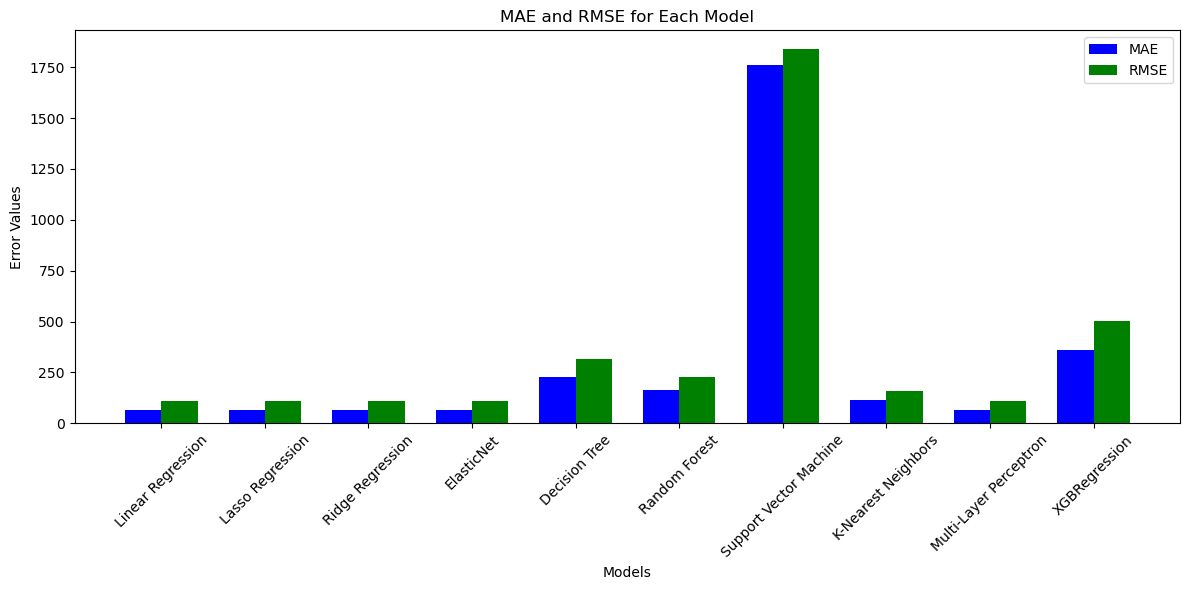

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(len(models))
bar_width = 0.35

bar1 = ax.bar(index, mae_values, bar_width, label='MAE', color='blue')
bar2 = ax.bar(index + bar_width, rmse_values, bar_width, label='RMSE', color='green')

ax.set_xlabel('Models')
ax.set_ylabel('Error Values')
ax.set_title('MAE and RMSE for Each Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models.keys(), rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [15]:
model = Model(MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000))

predictions, mae, rmse = model.predict(BTC_3600)

/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 70.25679394306387
Root Mean squared Error - RMSE : 112.72701395159125
----------------------------------------------------------------------------------------------------


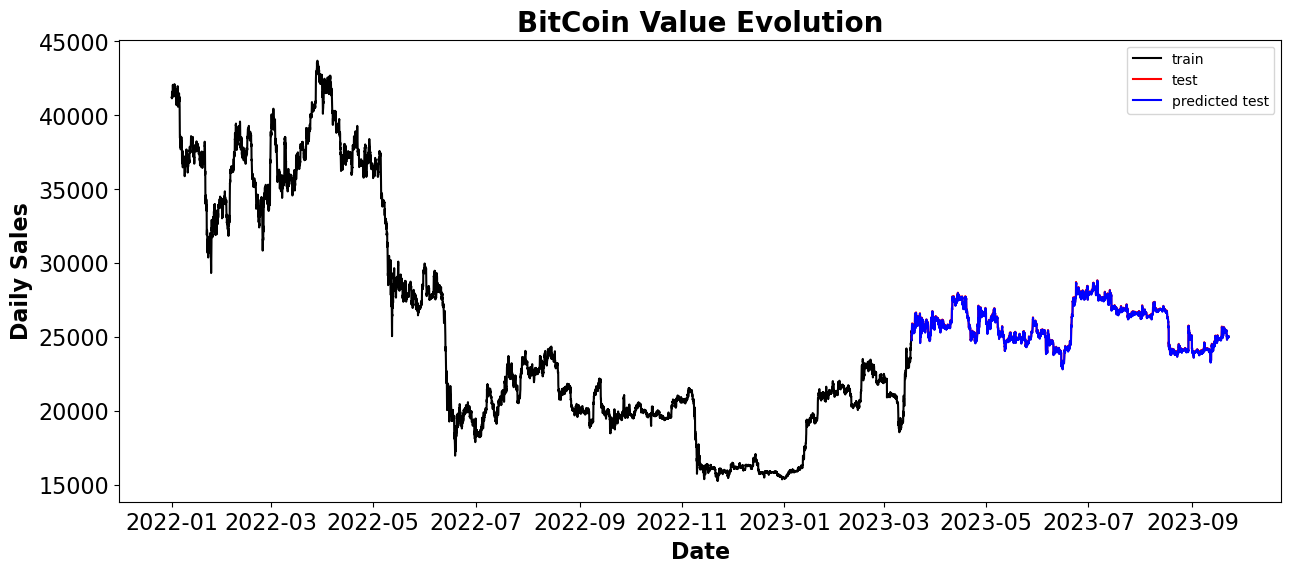

In [16]:
model.plot_predictions(BTC_3600, predictions)

Train ratio: 0.6
Test ratio: 0.4


/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 66.69948262334854
Root Mean squared Error - RMSE : 113.02357900909061
----------------------------------------------------------------------------------------------------


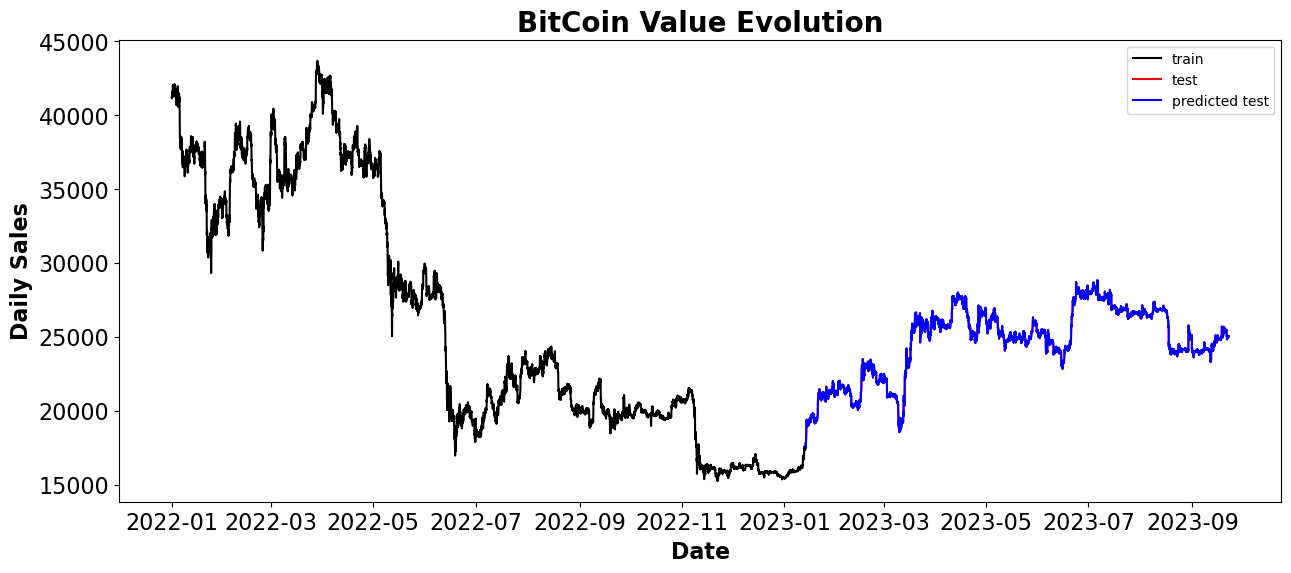

In [17]:
BTC_3600.reset_train_test(train_ratio=0.6)

predictions, mae, rmse = model.predict(BTC_3600)

model.plot_predictions(BTC_3600, predictions)

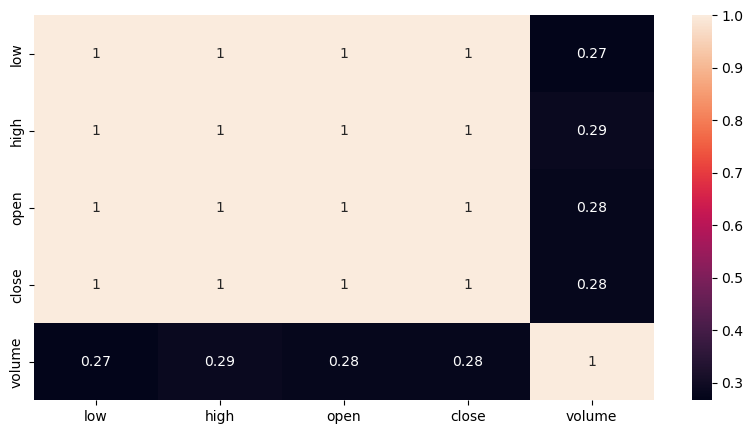

In [18]:
BTC_3600.plot_heatmap()

# TIME SERIES MODELS APPROACH

### CHECKING SEASONALITY

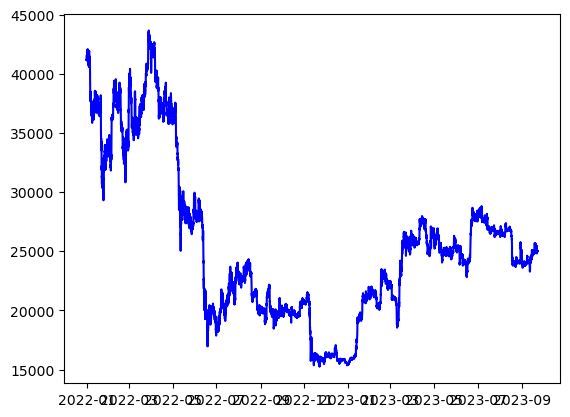

In [19]:
plt.figure()
plt.plot(BTC_3600.dataset['close'], color='blue')
plt.show()


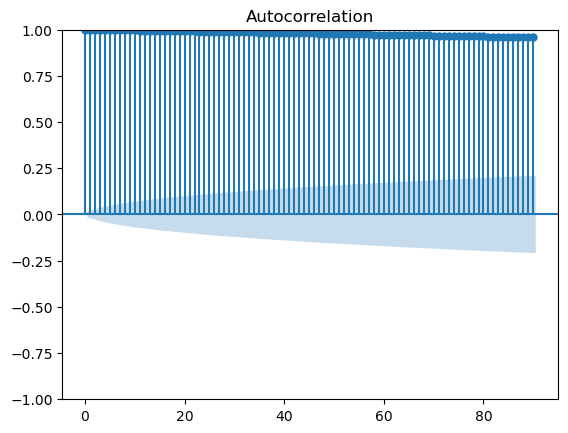

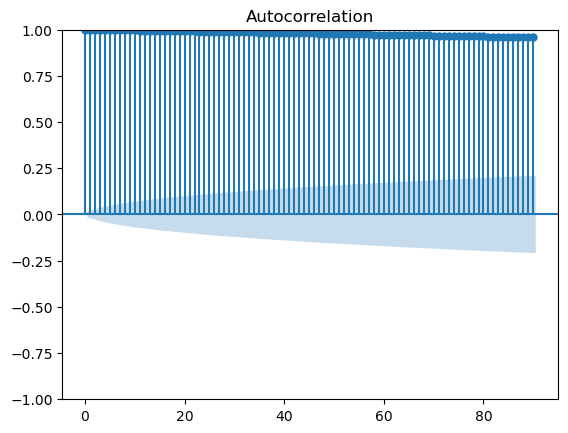

In [20]:
plot_acf(BTC_3600.dataset['close'], lags=90)

In [21]:
BTC_3600.dicker_fuller('close')

Dickey-Fuller Test indicates:
Test Statistic                    -1.925070
p-value                            0.641581
#Lags Used                        31.000000
Number of Observations Used    15072.000000
dtype: float64


/home/marc/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


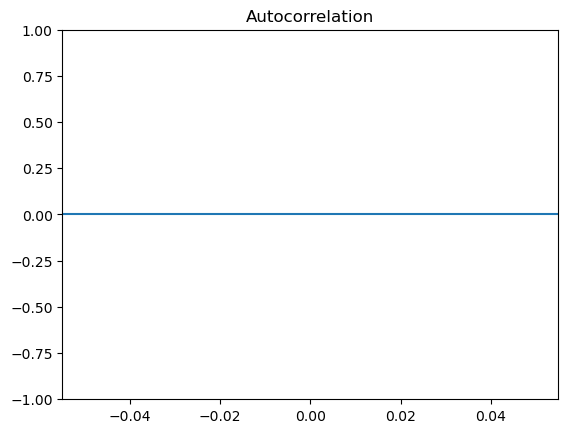

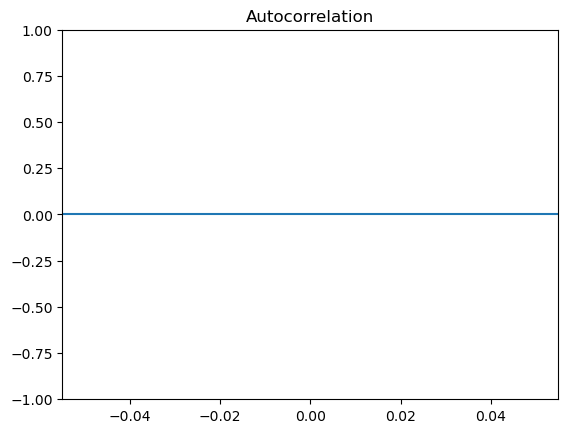

In [22]:
plot_acf(BTC_3600.dataset['close'].diff(periods=1), lags=90)

### SARIMAX

In [23]:
order = (2, 1, 2)  # Ordre (p, d, q)
seasonal_order = (2, 1, 2, 12)  # Ordre estacional (P, D, Q, s)

model = Model(SARIMAX(BTC_3600.train['close'], order=order, seasonal_order=seasonal_order))
results = model.fit()

/home/marc/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/marc/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.74248D+00    |proj g|=  2.40316D-02

At iterate    5    f=  6.72472D+00    |proj g|=  8.77887D-03

At iterate   10    f=  6.72269D+00    |proj g|=  3.07958D-03

At iterate   15    f=  6.62665D+00    |proj g|=  5.36885D-03

At iterate   20    f=  6.62587D+00    |proj g|=  5.37771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     29      1     0     0   8.657D-06   6.626D+00
  F =   6.6258676396336060     

CONVERG

In [24]:
forecast = results.get_forecast(steps=len(BTC_3600.test['close']))

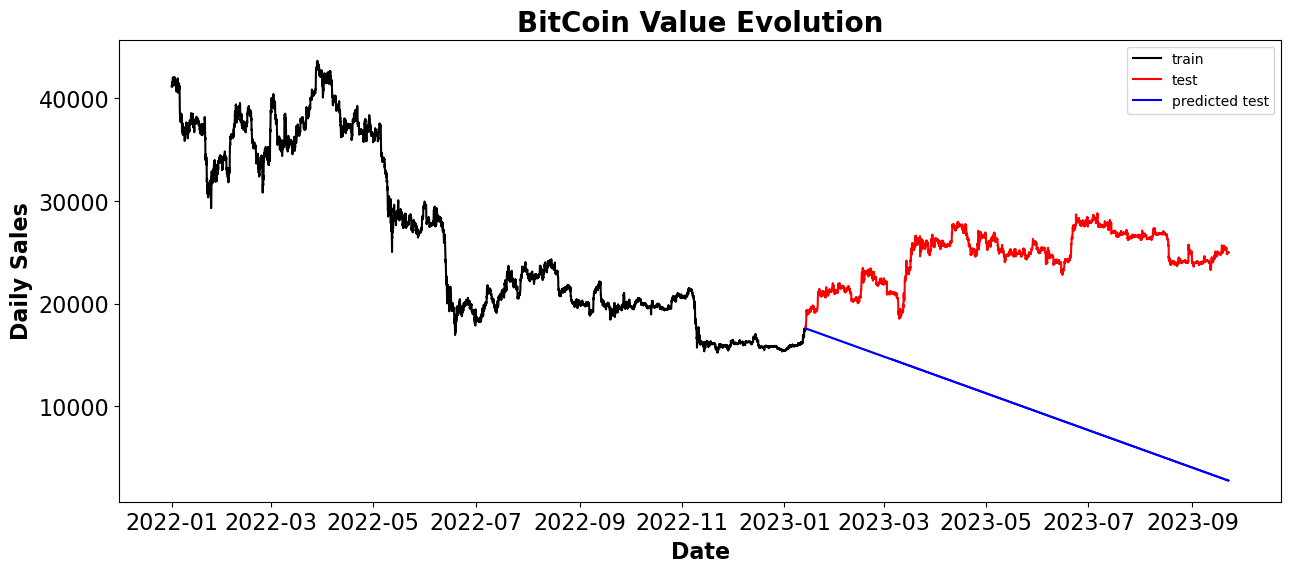

In [25]:
model.plot_predictions(BTC_3600, forecast.predicted_mean.values)

El problema amb SARIMAX és que només admet una única columna, i això fa que les prediccions siguin molt dolentes. Vaig a aplicar un model que accepti més dades com a input.

### VECTOR AUTOREGRESSION

/home/marc/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


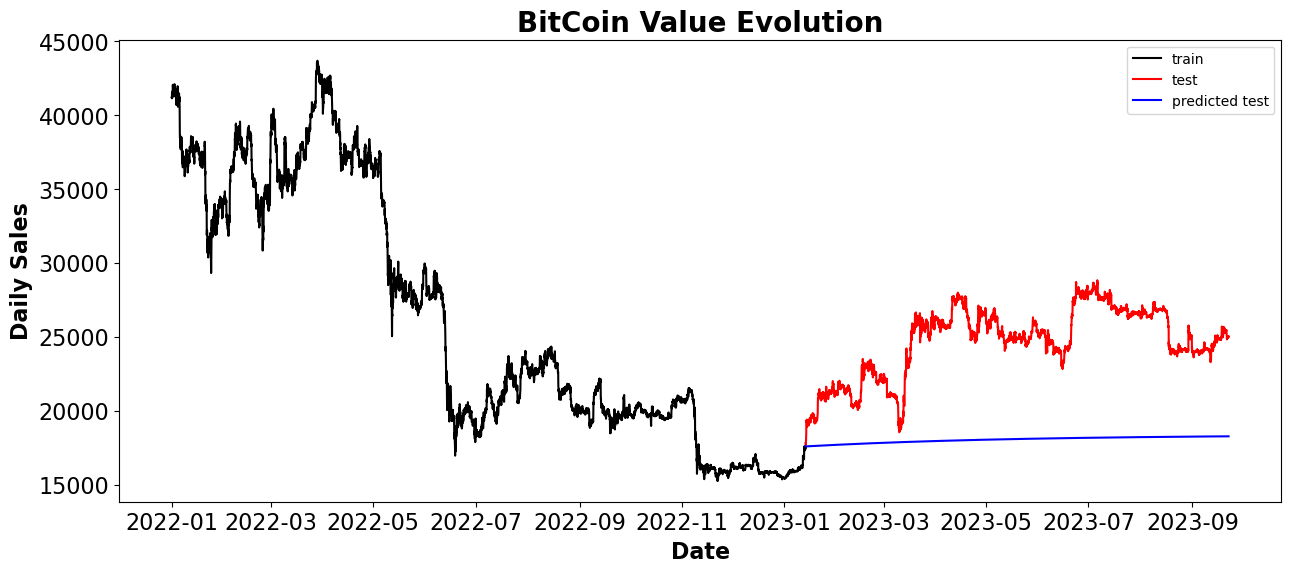

In [26]:
from statsmodels.tsa.api import VAR

# Suposem que 'data' és el teu DataFrame de dades multivariades
model = Model(VAR(BTC_3600.train))
results = model.fit()

# Fes prediccions
forecast = results.forecast(BTC_3600.train.values, steps=len(BTC_3600.test.values))
close_forecast = forecast[:, BTC_3600.dataset.columns.get_loc('close')]

model.plot_predictions(BTC_3600, close_forecast)

### VARX

/home/marc/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


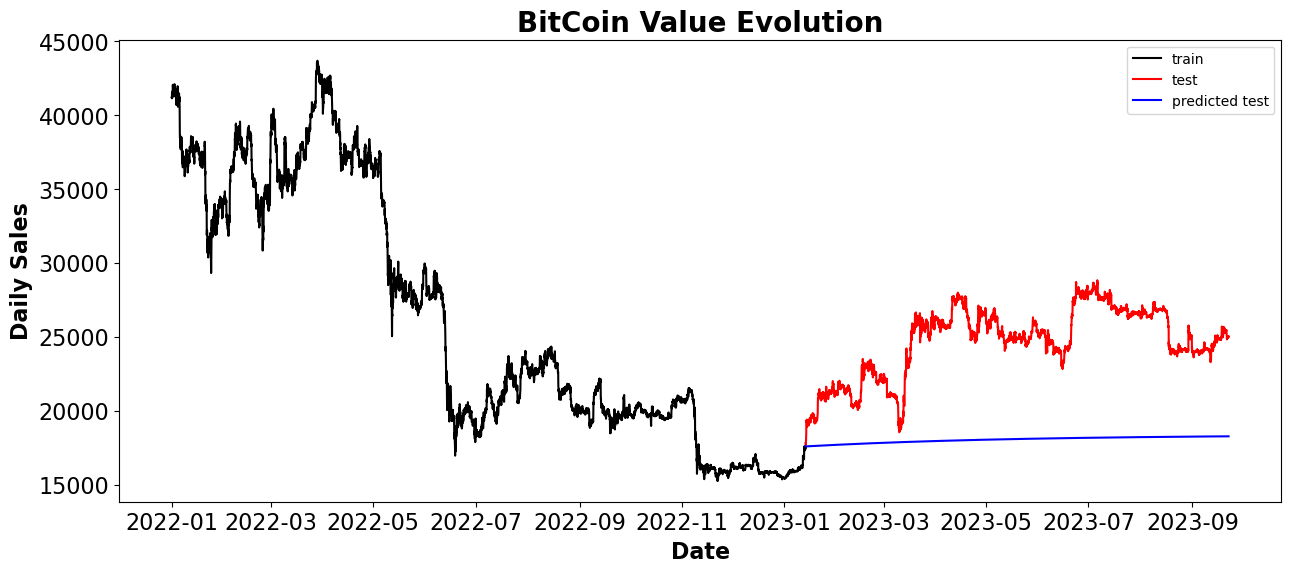

In [47]:
model = Model(sm.tsa.VARMAX(BTC_3600.train, order=(2,0), error_cov_type='diagonal'))
result = model.model.fit(maxiter=1000, disp=False)

forecast = results.forecast(BTC_3600.train.values, steps=len(BTC_3600.test.values))
close_forecast = forecast[:, BTC_3600.dataset.columns.get_loc('close')]

model.plot_predictions(BTC_3600, close_forecast)

### VMA

/home/marc/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


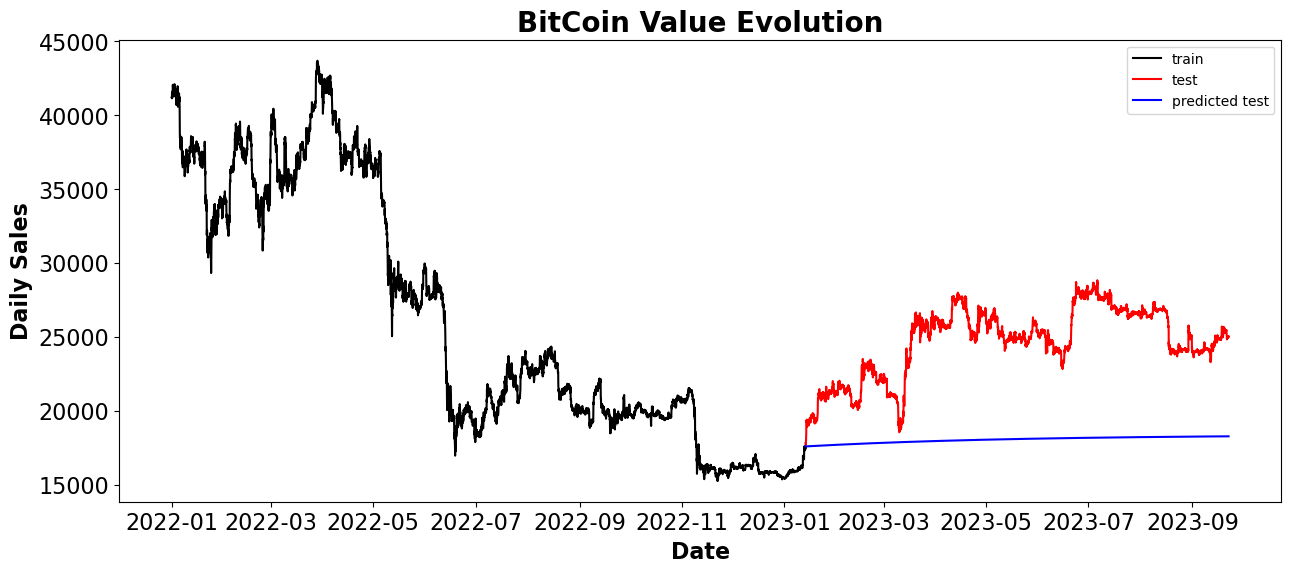

In [48]:
model = Model(sm.tsa.VARMAX(BTC_3600.train, order=(0,2), error_cov_type='diagonal'))
result = model.model.fit(maxiter=1000, disp=False)

forecast = results.forecast(BTC_3600.train.values, steps=len(BTC_3600.test.values))
close_forecast = forecast[:, BTC_3600.dataset.columns.get_loc('close')]

model.plot_predictions(BTC_3600, close_forecast)

### VARMA

/home/marc/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/marc/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


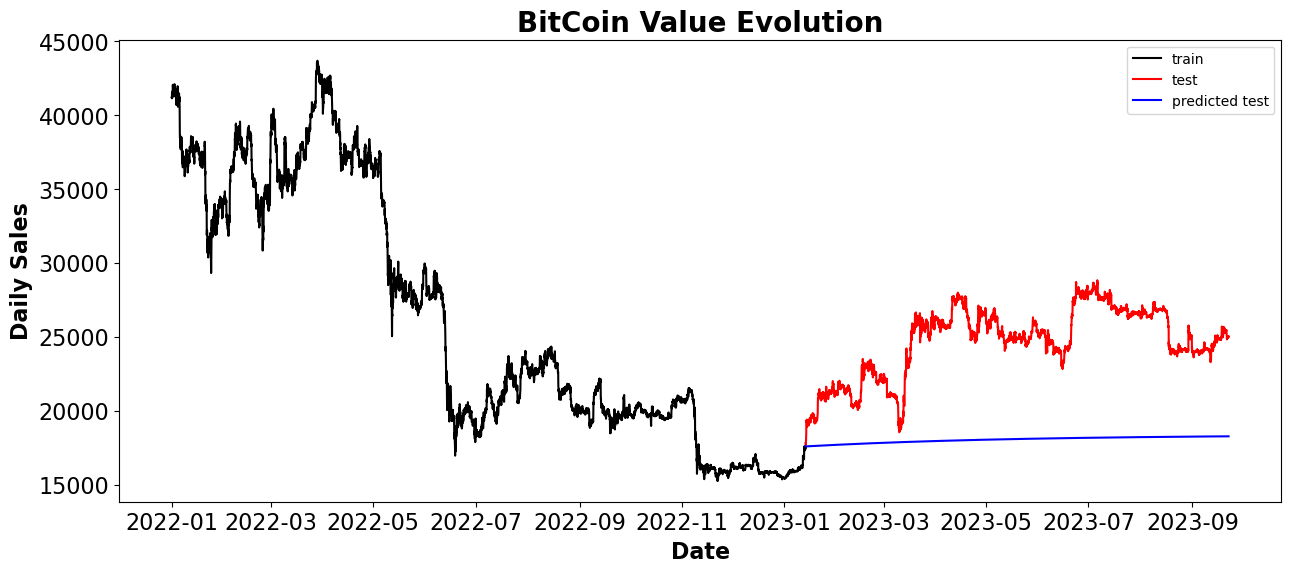

In [49]:
import statsmodels.api as sm

# Suposem que 'data' és el teu DataFrame de dades multivariades
model = Model(sm.tsa.VARMAX(BTC_3600.train, order=(1,1)))
result = model.model.fit(maxiter=1000, disp=False)

# Fes prediccions
forecast = results.forecast(BTC_3600.train.values, steps=len(BTC_3600.test.values))
close_forecast = forecast[:, BTC_3600.dataset.columns.get_loc('close')]

model.plot_predictions(BTC_3600, close_forecast)

Cap dels models vist anteriorment s'ajusta bé a les dades

Ara vaig a provar de descompondre les dades en tendència, estacionalitat i soroll, a veure si puc trobar un patró. Com que tinc moltes dades, les estudiaré fent servir intèrvals d'un mes

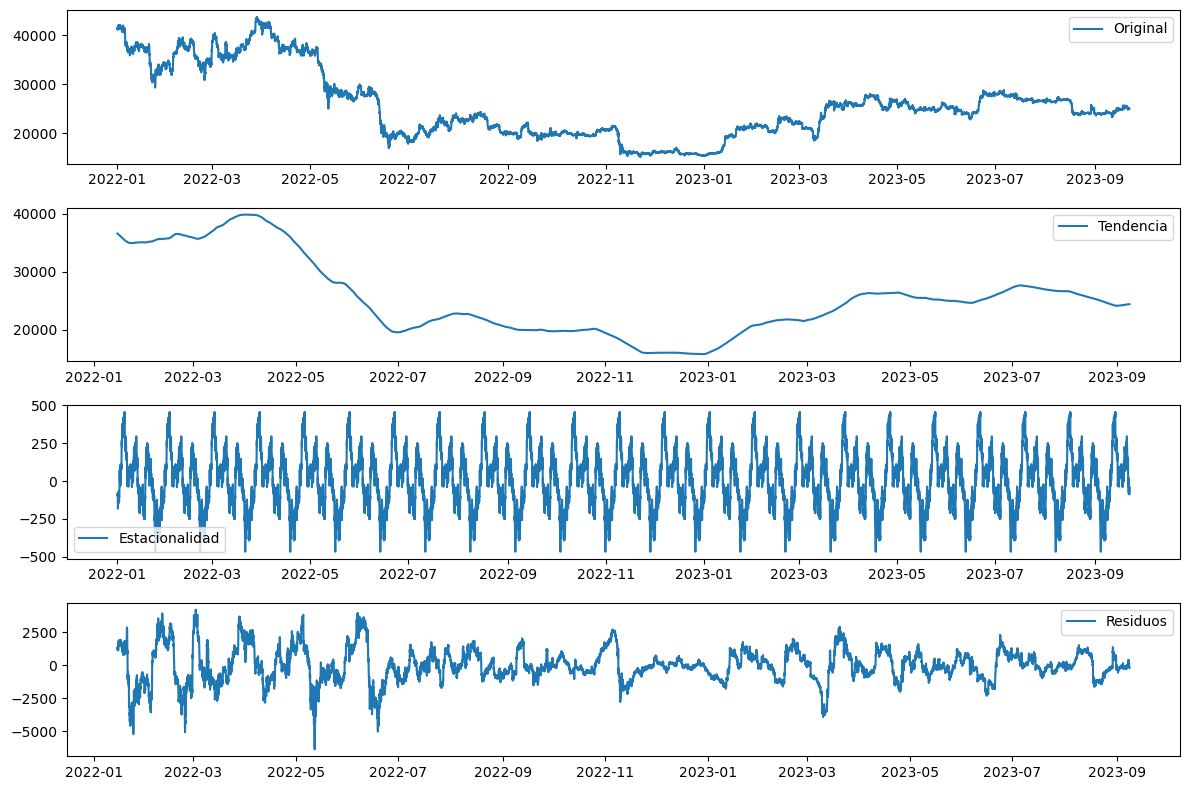

In [45]:
result = seasonal_decompose(BTC_3600.dataset['close'], model='additive', period=672) # intèrvals d'un mes

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(BTC_3600.dataset['close'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuos')
plt.legend()

plt.tight_layout()
plt.show()